# Assignment 2 - Data Science for Business II

## Ly Tran - 590387

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
!pip install lifelines
import lifelines as lifelines

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Import dataset

In [34]:
machine_data = pd.read_csv(
    'machine.csv')
machine_data.head()

,energy_level,type,time,status,weight,size,utility
0,1,A,72,1,60,7,69
1,1,A,411,1,70,5,64
2,1,A,228,1,60,3,38
3,1,A,126,1,60,9,63
4,1,A,118,1,70,11,65


In [35]:
machine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 7 columns):
energy_level    137 non-null int64
type            137 non-null object
time            137 non-null int64
status          137 non-null int64
weight          137 non-null int64
size            137 non-null int64
utility         137 non-null int64
dtypes: int64(6), object(1)
memory usage: 7.6+ KB


### Plot Kaplan-Meier survival curve

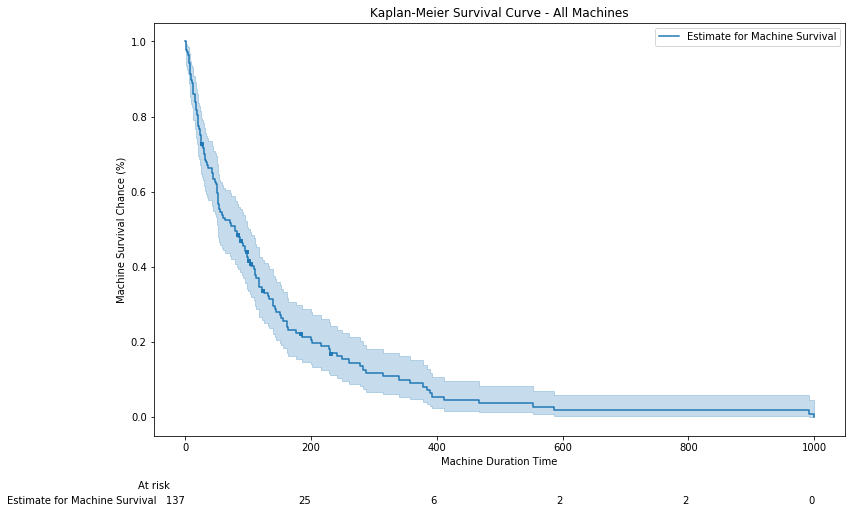

In [56]:
# fitting kmf to the data
Time = machine_data['time'].values
Closed = machine_data['status'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(Time, event_observed=Closed, label='Estimate for Machine Survival')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(12,7))
kmf.plot(ax=ax,show_censors=True, censor_styles={'ms': 3, 'marker': 's'},at_risk_counts=True)
ax.set_title('Kaplan-Meier Survival Curve - All Machines')
ax.set_xlabel('Machine Duration Time')
ax.set_ylabel('Machine Survival Chance (%)')
plt.show()

### Interpretation

The y-axis represents the probability a machine is still around after 𝑡 time units, where 𝑡 time unit is on the x-axis.

About 20% machines survived more than 200 time units.

In [37]:
# Lifetable 
kmf.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,137,137
1.0,2,2,0,0,137
2.0,1,1,0,0,135
3.0,1,1,0,0,134
4.0,1,1,0,0,133


### Plot Kaplan-Meier survival curve with different energy level and compare the difference(check logrank test result)

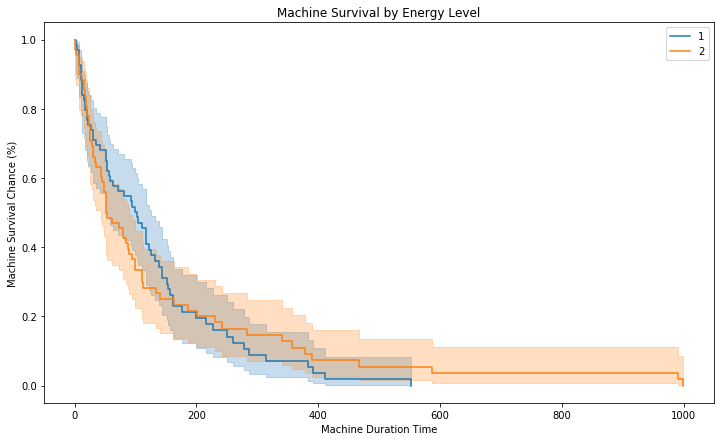

In [38]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='time', event='status', df=machine_data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

# plot by education level
fig_edl, ax_edl = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='energy_level', ax=ax_edl)
ax_edl.set_title('Machine Survival by Energy Level')
ax_edl.set_xlabel('Machine Duration Time')
ax_edl.set_ylabel('Machine Survival Chance (%)')
plt.show()

In [39]:
# check survival curves for different energy levels
level1 = (machine_data["energy_level"] == 1)
T = machine_data["time"]
E = machine_data["status"]
kmf.fit(T[level1], event_observed=E[level1])

from lifelines.statistics import logrank_test

machine_energy_level_results = logrank_test(T[level1], T[~level1], E[level1], E[~level1], alpha=.99)

machine_energy_level_results.print_summary()

### Interpretation

The log-rank test provided a p-value of 0.93 (greater than significant level 0.01) indicating that the difference in survival between energy levels was not statistically significant. We continue believing that null hypothesis is true, meaning we continue believing that survival rate for different energy levels do not differ.

### Apply the cox model to the data, check coefficients’ values and c-index

In [40]:
#change the binary variables to True and False
machine_data['energy_level'] = machine_data['energy_level'] == 1   
    
# one-hot encode the categorical features
ohe_features = ['type']
machine_data = pd.get_dummies(machine_data, 
                              drop_first=True,
                              columns=ohe_features)
machine_data.head()

,energy_level,time,status,weight,size,utility,type_B,type_C,type_D
0,True,72,1,60,7,69,0,0,0
1,True,411,1,70,5,64,0,0,0
2,True,228,1,60,3,38,0,0,0
3,True,126,1,60,9,63,0,0,0
4,True,118,1,70,11,65,0,0,0


In [41]:
machine_cph = lifelines.CoxPHFitter()
machine_cph.fit(machine_data, duration_col='time', event_col='status', show_progress=False)
machine_cph.print_summary()

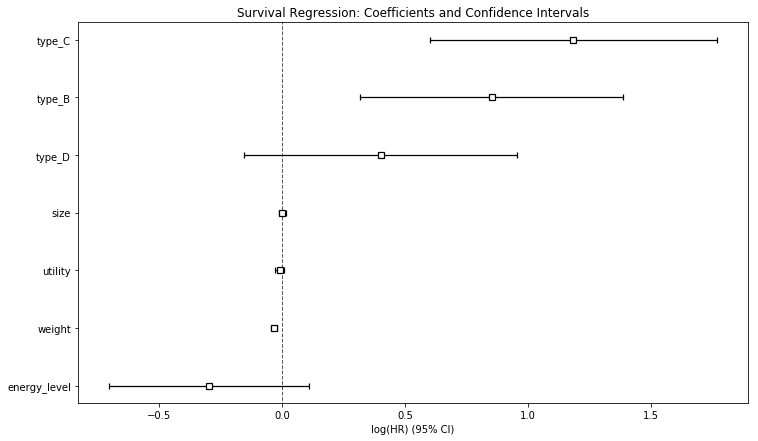

In [42]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confidence Intervals')
machine_cph.plot(ax=ax_coef);

### Check survival rate in different covariate group (different utility values)

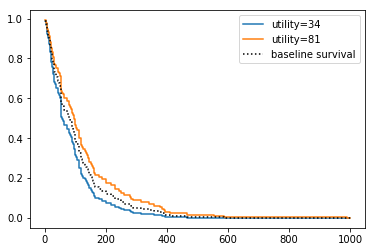

In [49]:
# check numerical covariate
#startup_cph.plot_covariate_groups('TimeGetSeedFunding', values=np.arange(18,100,30));
machine_cph.plot_covariate_groups('utility', values=[34,81]);

In [44]:
machine_data.describe()

,time,status,weight,size,utility,type_B,type_C,type_D
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,121.627737,0.934307,58.569343,8.773723,58.306569,0.350365,0.197080,0.197080
std,157.816722,0.248655,20.039592,10.612141,10.541628,0.478835,0.399253,0.399253
min,1.000000,0.000000,10.000000,1.000000,34.000000,0.000000,0.000000,0.000000
25%,25.000000,1.000000,40.000000,3.000000,51.000000,0.000000,0.000000,0.000000
50%,80.000000,1.000000,60.000000,5.000000,62.000000,0.000000,0.000000,0.000000
75%,144.000000,1.000000,75.000000,11.000000,66.000000,1.000000,0.000000,0.000000
max,999.000000,1.000000,99.000000,87.000000,81.000000,1.000000,1.000000,1.000000
